# The Complete Machine Learning

## Máquinas de Vectores de Soporte (SVM) con el dataset Iris

* **Qué es:** Un conjunto de algoritmos de Machine Learning muy potentes y versátiles, capaces de realizar clasificación (lineal y no lineal) y regresión.
* **Idea Central (Clasificación):** SVM no solo busca una línea (o hiperplano) que separe las clases, sino que busca encontrar la "calle" (el **margen**) más ancha posible que separe las clases.
* **Vectores de Soporte:** Los puntos de los datos que están en el borde de esta "calle" (los más cercanos a la línea de separación) se llaman **Vectores de Soporte**. Son los únicos puntos que "sostienen" el modelo. 
* **¡MUY IMPORTANTE!** Los modelos SVM son **extremadamente sensibles al escalado de las variables**. Es casi obligatorio usar `StandardScaler` antes de entrenar un SVM.

### (Preparación) Carga y Preparación del dataset Iris

Usaremos el dataset **Iris** porque es pequeño, rápido y perfecto para *visualizar* los márgenes. Para poder graficar en 2D, usaremos solo dos "features": **largo del pétalo** y **ancho del pétalo**, que ofrecen buena separación.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.metrics import accuracy_score, mean_squared_error

# --- (Función de ayuda para graficar las fronteras de decisión) ---
# (No es necesario entenderla al 100%, solo usarla)
# Esta función se usará en las celdas siguientes
def plot_decision_boundary(clf, X, y, title):
    # Cargar nombres para los labels (asumiendo que 'iris' está cargado)
    iris_data = datasets.load_iris()
    
    # Definir rangos del gráfico
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Predecir en toda la "rejilla"
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Colores
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ['red', 'green', 'blue']
    
    # Graficar
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)
    
    # Graficar los puntos de datos (solo los de train)
    for i, color in zip(range(3), cmap_bold):
        plt.scatter(X[y==i, 0], X[y==i, 1], c=color, 
                    label=iris_data.target_names[i], edgecolor='k')
        
    plt.title(title)
    plt.xlabel(f"{iris_data.feature_names[2]} (scaled)")
    plt.ylabel(f"{iris_data.feature_names[3]} (scaled)")
    plt.legend()
    plt.show()

# --- 1. Cargar el dataset Iris ---
iris = datasets.load_iris()

# --- 2. Seleccionar SOLO 2 features para poder visualizar ---
# feature 2: Petal length (cm)
# feature 3: Petal width (cm)
X = iris.data[:, [2, 3]]
y = iris.target # 0=Setosa, 1=Versicolor, 2=Virginica

# --- 3. Dividir en Train y Test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- 4. !! PASO OBLIGATORIO: Escalar los datos !! ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Datos listos. {X_train_scaled.shape[0]} muestras de train, {X_test_scaled.shape[0]} de test.")
print(f"Features: {iris.feature_names[2]} y {iris.feature_names[3]}")

Datos listos. 105 muestras de train, 45 de test.
Features: petal length (cm) y petal width (cm)


### 1. Clasificación SVM Lineal (Linear SVM Classification)

* **Qué es:** La versión más básica de SVM. Asume que los datos se pueden separar limpiamente con una línea recta (o un plano).
* **Hiperparámetro `C`:** Es el inverso de la regularización. Controla el "margen suave" (soft margin).
    * `C` **bajo**: Regularización alta. Permite *más violaciones* (una "calle" más ancha). Generaliza mejor.
    * `C` **alto**: Regularización baja. Intenta clasificar *correctamente* cada punto (una "calle" más estrecha). Puede sobreajustar.

* **Nota:** Se asume que las variables `X_train_scaled`, `y_train`, `X_test_scaled`, `y_test` y la función `plot_decision_boundary` existen de la celda de preparación anterior.


--- Ejecutando LinearSVC ---
Accuracy de LinearSVC: 0.8889


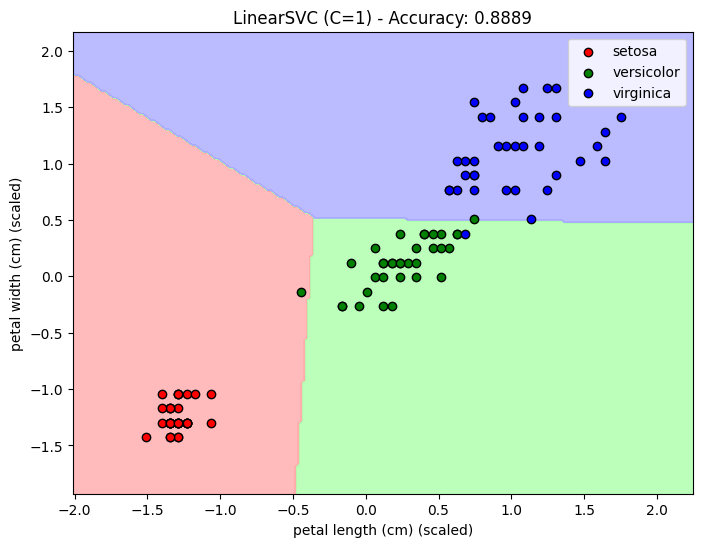

In [7]:
# --- Imports para este bloque ---
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt  # Asegurarse de que plt esté disponible para plot_decision_boundary

# 1. Entrenar el modelo (C=1, un valor equilibrado)
# Usamos LinearSVC, que está optimizado solo para el kernel lineal
print("\n--- Ejecutando LinearSVC ---")
linear_svc = LinearSVC(C=1, random_state=42, dual="auto") # dual="auto" evita warnings
linear_svc.fit(X_train_scaled, y_train)

# 2. Evaluar
y_pred_linear = linear_svc.predict(X_test_scaled)
acc_linear = accuracy_score(y_test, y_pred_linear)
print(f"Accuracy de LinearSVC: {acc_linear:.4f}")

# 3. Visualizar la frontera
# (La función plot_decision_boundary fue definida en la celda anterior)
plot_decision_boundary(linear_svc, X_train_scaled, y_train, 
                       title=f"LinearSVC (C=1) - Accuracy: {acc_linear:.4f}")

# Interpretación del Gráfico:** Verás cómo `LinearSVC` traza líneas rectas para separar las 3 clases. 
# La clase Setosa (roja) es fácil de separar 
# Versicolor y Virginica (verde y azul) están más mezcladas, pero la línea intenta encontrar el mejor corte posible.

### 2. El Truco del Kernel (Kernel Trick)

* **El Problema:** El SVM Lineal (LinearSVC) es rápido y eficiente, pero falla si los datos no son separables con una línea recta. (Imagina un grupo de puntos en el centro y otro grupo formando un anillo alrededor).

* **La Solución (Teórica):** Podríamos añadir nuevas "features" (como $x^2$, $y^2$) para proyectar los datos a una dimensión superior donde *sí* sean linealmente separables.

* **El "Truco" (Práctico):** Esta proyección puede ser computacionalmente muy costosa. El "Truco del Kernel" es una proeza matemática que permite obtener el *resultado* de esa proyección (como si estuviéramos en la dimensión alta) **sin tener que crear nunca las features adicionales**. 

* **En `sklearn`:** Usamos la clase `SVC` (en lugar de `LinearSVC`) y especificamos el `kernel` que queremos usar.

### 3. Kernel Polinómico (Polynomial Kernel)

* **Qué es:** Un kernel que simula añadir características polinómicas.
* **Resultado:** Permite al SVM encontrar fronteras de decisión curvas.
* **Hiperparámetros clave:**
    * `kernel='poly'`: Le dice a `SVC` que use este kernel.
    * `degree`: El grado del polinomio (ej. `degree=3` para cúbico). Un grado alto puede sobreajustar.
    * `C`: El parámetro de regularización (igual que en LinearSVC).


--- Ejecutando SVM Polinómico ---
Accuracy de SVM Polinómico (grado 3): 0.9111


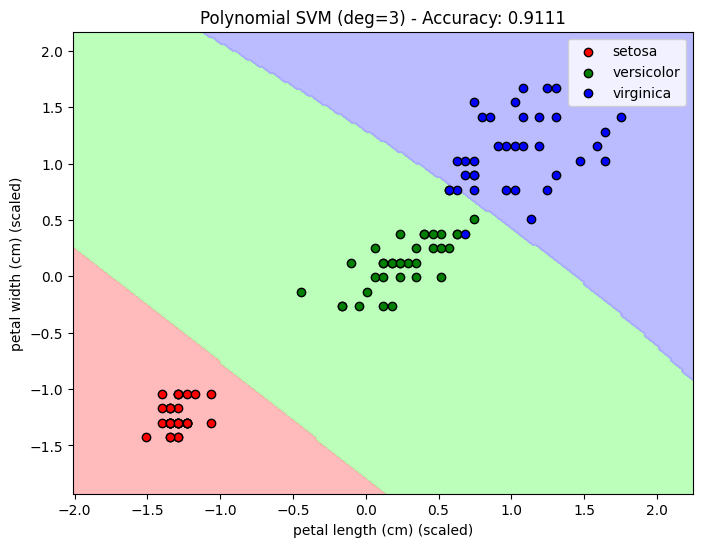

In [8]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

print("\n--- Ejecutando SVM Polinómico ---")
# 1. Entrenar el modelo
# Ahora usamos 'SVC' que permite elegir kernels
# Probamos con un polinomio de grado 3
poly_svm = SVC(kernel='poly', degree=3, C=1, random_state=42)
poly_svm.fit(X_train_scaled, y_train)

# 2. Evaluar
y_pred_poly = poly_svm.predict(X_test_scaled)
acc_poly = accuracy_score(y_test, y_pred_poly)
print(f"Accuracy de SVM Polinómico (grado 3): {acc_poly:.4f}")

# 3. Visualizar
# (La función plot_decision_boundary fue definida en la celda anterior)
plot_decision_boundary(poly_svm, X_train_scaled, y_train, 
                       title=f"Polynomial SVM (deg=3) - Accuracy: {acc_poly:.4f}")

# Notarás que las fronteras ya no son líneas rectas.
# Se curvan (sutilmente en este dataset) para intentar "rodear" mejor los grupos.

### 4. Kernel Gaussiano RBF (Gaussian Radial Basis Function)

* **Qué es:** El kernel más popular, potente y flexible. Es la opción por defecto en `SVC` (`kernel='rbf'`).
* **Cómo funciona:** Mide la "similitud" de cada punto con los demás basándose en una función Gaussiana (como una campana de Gauss). Cada punto de datos se convierte en un "centro de influencia".
* **Sirve para:** Modelar fronteras de decisión extremadamente complejas y orgánicas.
* **Hiperparámetros clave:**
    * `C`: El parámetro de regularización (controla el margen, igual que antes).
    * `gamma`: Controla el "ancho" de la campana Gaussiana (la influencia de un solo punto).
        * `gamma` **bajo**: Influencia amplia. La frontera de decisión es muy suave (tiende al *underfitting*).
        * `gamma` **alto**: Influencia estrecha. Cada punto influye solo localmente. La frontera es muy irregular y se adapta al ruido (tiende al *overfitting*).



--- Ejecutando SVM RBF ---
Accuracy de SVM RBF: 0.9111


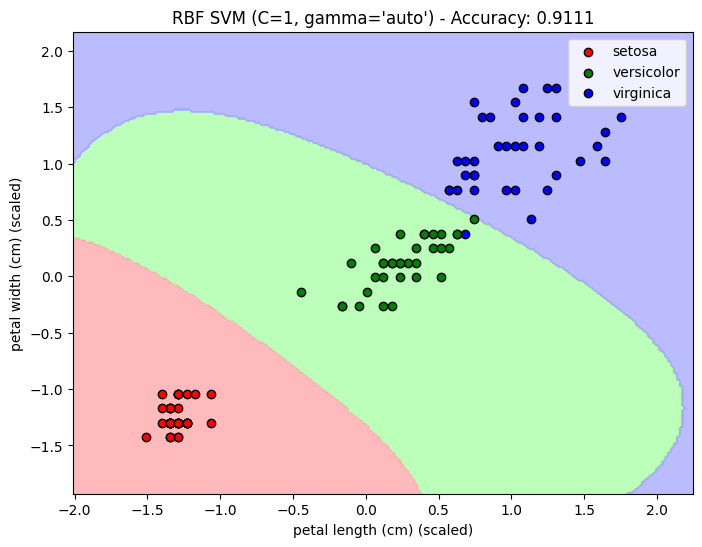

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

print("\n--- Ejecutando SVM RBF ---")
# 1. Entrenar el modelo
# 'gamma='auto'' es un buen punto de partida, calcula 1 / n_features
rbf_svm = SVC(kernel='rbf', C=1, gamma='auto', random_state=42)
rbf_svm.fit(X_train_scaled, y_train)

# 2. Evaluar
y_pred_rbf = rbf_svm.predict(X_test_scaled)
acc_rbf = accuracy_score(y_test, y_pred_rbf)
print(f"Accuracy de SVM RBF: {acc_rbf:.4f}")

# 3. Visualizar
# (La función plot_decision_boundary fue definida en la celda anterior)
plot_decision_boundary(rbf_svm, X_train_scaled, y_train, 
                       title=f"RBF SVM (C=1, gamma='auto') - Accuracy: {acc_rbf:.4f}")

# Verás fronteras muy suaves y flexibles que se adaptan excelentemente a la forma de los grupos. 
# Este suele ser el kernel más efectivo para la mayoría de los problemas. 

### 5. Búsqueda en Rejilla (Grid Search)

* **Qué es:** Es el método estándar para encontrar la **mejor combinación de hiperparámetros** (ej. los mejores `C` y `gamma` para un SVM RBF).
* **Cómo funciona:**
    1.  Se define una "rejilla" (un diccionario) con los valores que se quieren probar (ej. `C: [0.1, 1, 10]`, `gamma: [0.1, 1]`).
    2.  `GridSearchCV` prueba **todas las combinaciones posibles** (ej. 3x2 = 6 combinaciones).
    3.  Usa **Validación Cruzada (K-Fold)** internamente para evaluar cada combinación de forma robusta.
    4.  Al final, reporta la combinación que dio el mejor *score* promedio.
* **Ventaja con Iris:** Como el dataset es tan pequeño, `GridSearchCV` se ejecuta **en menos de un segundo**, a diferencia de datasets grandes donde puede tardar horas.


--- Ejecutando GridSearchCV ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits

¡Búsqueda completada!
Mejores parámetros encontrados: {'C': 0.1, 'gamma': 0.01}
Mejor accuracy (promedio de CV): 0.9810


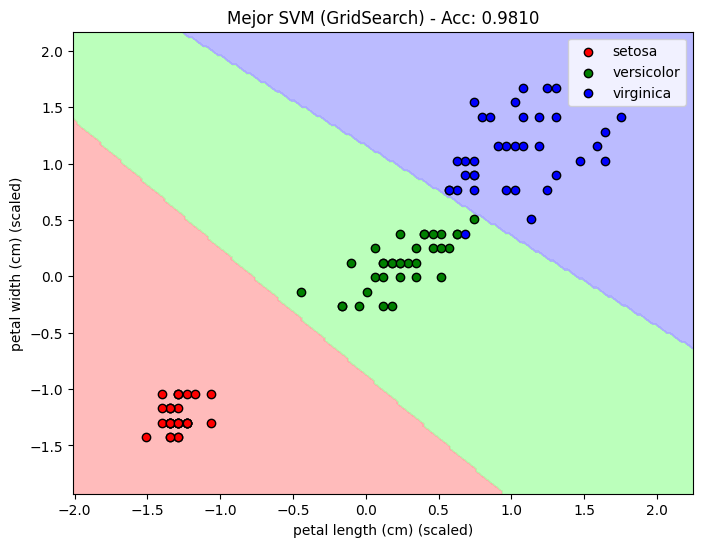

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import matplotlib.pyplot as plt

print("\n--- Ejecutando GridSearchCV ---")

# 1. Definir la rejilla de parámetros a probar
# (Una rejilla 4x4 = 16 combinaciones)
param_grid = {
    'C': [0.1, 1, 10, 100],          # Probar 4 valores para C
    'gamma': [0.01, 0.1, 1, 'auto'] # Probar 4 valores para gamma
}

# 2. Configurar la búsqueda
# 'estimator' = el modelo base que queremos optimizar
# 'cv=5' -> 5-fold cross-validation (Total: 16 combos * 5 folds = 80 modelos a entrenar)
# 'scoring='accuracy'' -> Métrica a optimizar
# 'n_jobs=-1' -> Usar todos los procesadores de la CPU en paralelo
# 'verbose=1' -> Muestra algo de progreso
grid_search = GridSearchCV(
    SVC(kernel='rbf', random_state=42), 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1,
    verbose=1
)

# 3. Ejecutar la búsqueda (¡En Iris es casi instantáneo!)
grid_search.fit(X_train_scaled, y_train)

# 4. Ver los mejores parámetros encontrados
print("\n¡Búsqueda completada!")
print(f"Mejores parámetros encontrados: {grid_search.best_params_}")
print(f"Mejor accuracy (promedio de CV): {grid_search.best_score_:.4f}")

# 5. Visualizar el MEJOR modelo encontrado
# 'grid_search.best_estimator_' es el modelo ya re-entrenado
# con los mejores parámetros sobre *todo* el X_train_scaled
mejor_svm = grid_search.best_estimator_

plot_decision_boundary(mejor_svm, X_train_scaled, y_train, 
                       title=f"Mejor SVM (GridSearch) - Acc: {grid_search.best_score_:.4f}")

# GridSearch nos da la combinación de `C` y `gamma` que produce el mejor accuracy promedio en la validación cruzada, 
# encontrando el "punto dulce" del tradeoff sesgo-varianza.


### 6. Regresión de Vectores de Soporte (Support Vector Regression - SVR)

* **Qué es:** La versión de SVM para problemas de **REGRESIÓN** (predecir un valor numérico).
* **Cómo funciona:** Es la idea *inversa* de SVM Clasificación.
    * En lugar de encontrar la "calle" (margen) *más ancha* que **separa** las clases...
    * ...SVR intenta encontrar una "calle" (margen) que **contenga** la *mayor cantidad de puntos de datos posible*.
* **Hiperparámetro `epsilon` (ε):**
    * Define el ancho de esta "calle".
    * Los puntos que caen **dentRO** de la calle (margen de error $\pm\epsilon$) **no penalizan** al modelo.
    * El modelo solo es penalizado por los puntos que caen **fuera** de la calle.
* **Ejemplo con Iris:** Vamos a predecir el `Ancho del Pétalo` (y) basándonos en el `Largo del Pétalo` (X).


--- Ejecutando SVR ---


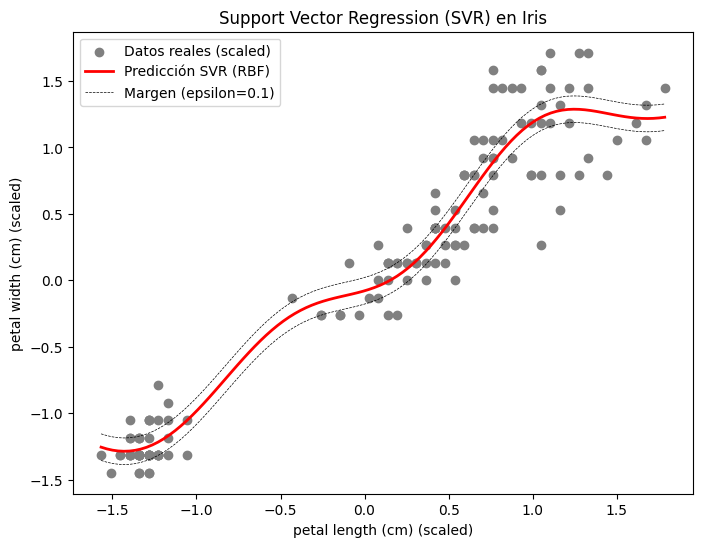

In [11]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

print("\n--- Ejecutando SVR ---")

# 1. Preparar datos para Regresión (1 feature -> 1 target)
# Usaremos 'Petal length' (X) para predecir 'Petal width' (y)
# (iris dataset ya debería estar cargado de la celda 1)
X_reg = iris.data[:, [2]] # Petal length (reshape a 2D para scaler)
y_reg = iris.data[:, 3]  # Petal width (1D)

# 2. Escalar X e y
# (En regresión, a veces también es útil escalar 'y')
scaler_X_reg = StandardScaler()
scaler_y_reg = StandardScaler()

X_reg_scaled = scaler_X_reg.fit_transform(X_reg)
# .reshape(-1, 1) para 2D, .ravel() para volver a 1D
y_reg_scaled = scaler_y_reg.fit_transform(y_reg.reshape(-1, 1)).ravel()

# 3. Entrenar el modelo SVR
# Usamos el kernel 'rbf' que funcionó bien antes
# 'epsilon=0.1' define el ancho de la "calle" (en escala estándar)
svr_model = SVR(kernel='rbf', C=10, epsilon=0.1)
svr_model.fit(X_reg_scaled, y_reg_scaled)

# 4. Graficar los resultados
# Crear puntos de test para dibujar la línea
X_fit = np.linspace(X_reg_scaled.min(), X_reg_scaled.max(), 100).reshape(-1, 1)
y_pred = svr_model.predict(X_fit)

plt.figure(figsize=(8, 6))
plt.scatter(X_reg_scaled, y_reg_scaled, c='gray', label='Datos reales (scaled)')
plt.plot(X_fit, y_pred, color='red', lw=2, label='Predicción SVR (RBF)')

# Graficar la "calle" (margen de epsilon)
plt.plot(X_fit, y_pred + svr_model.epsilon, 'k--', lw=0.5, label=f"Margen (epsilon={svr_model.epsilon})")
plt.plot(X_fit, y_pred - svr_model.epsilon, 'k--', lw=0.5)

plt.title("Support Vector Regression (SVR) en Iris")
plt.xlabel(f"{iris.feature_names[2]} (scaled)")
plt.ylabel(f"{iris.feature_names[3]} (scaled)")
plt.legend()
plt.show()

# Interpretación del Gráfico:** * Verás la línea de regresión (roja) que predice el SVR. 
# La clave son las dos líneas punteadas (la "calle" de `epsilon`). El SVR intenta meter la mayor cantidad de puntos *dentro* de esa calle.
# Los puntos fuera de la calle (los vectores de soporte de regresión) son los que "tiran" de la línea. 